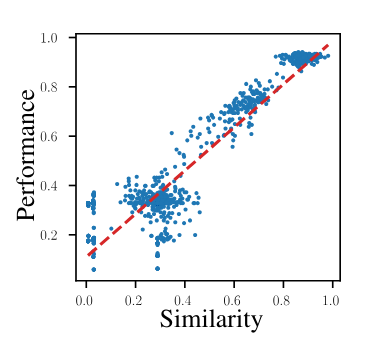

In this part, we are trying to replicate section 4.2 which is done on graphs. Theoretically (I don't know much about graphs) it should be possible to replace GNNs with another type of NN and investigate the results.
here we train 288 different models on several configs and investigate if better models have correlated latents or not!
based on the paper itself if latents are similar to a well-performing model latents then the models that generated those latents should perform well too. However, a well-performing model does not necessarily mean it should be similar to all (or other) good models.

we fine-tune a pre-trained model on CIFAR-10 based on various choices of hyperparameters

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from torch import cosine_similarity
import numpy as np
import pickle

# Configuration
is_resumed = False
CIFAR_test_size = 10000
dataset_path = './cifar-10'
!mkdir results


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10, num_channels=32, dropout_prob=0.5, activation='ReLU'):
        super(CNNModel, self).__init__()
        activation_fn = nn.ReLU if activation == 'ReLU' else nn.Tanh
        self.latent_dim = latent_dim
        self.network = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, padding=1),
            activation_fn(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),
            nn.BatchNorm2d(num_channels * 2),
            nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, padding=1),
            activation_fn(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),
            nn.BatchNorm2d(num_channels * 4),
            nn.Flatten(),
            nn.Linear(num_channels * 4 * 8 * 8, 256),
            activation_fn(),
            nn.Linear(256, self.latent_dim),
            activation_fn()
        )
        self.fc = nn.Linear(self.latent_dim, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
        self.latent = None

    def forward(self, x):
        self.latent = self.network(x)
        x = self.dropout(self.latent)
        x = self.fc(x)
        return x


# Define a function to train the model and track F1 score history
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scaler):
    f1_history = []
    latents_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        # Evaluate and store F1 score at the end of each epoch
        f1, latents = evaluate_model(model, test_loader)
        f1_history.append(f1)
        latents_history.append(latents)
    print(f"Train, Loss: {running_loss / len(train_loader):.4f}, F1 Score: {f1:.4f}")
    return f1_history, latents_history

# Define a function to evaluate the model and calculate F1 score
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    latent_idx = 0
    eval_latent = torch.empty((CIFAR_test_size, model.latent_dim), device=device)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            eval_latent[latent_idx:latent_idx+len(inputs)] = model.latent
            latent_idx += len(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1, eval_latent

# Hyperparameter grid
param_grid = {
    'seeds': [1, 2, 3],
    'num_channels': [32, 64],
    'dropout_prob': [0.1, 0.5],
    'activation': ['ReLU', 'Tanh'],
    'optimizer': ['SGD', 'Adam'],
    'learning_rate': [0.01, 0.02],
    'num_epochs': [5, 10, 20]
}


during the training we save latents and f1_scores of trained models to be able to plot the fine-tuned latents

In [2]:
# Define transformtaions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create data loaders with more workers
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

latest_saved_config_id = 0
for config_id, params in enumerate(ParameterGrid(param_grid)):
    print(config_id)
    results_dict = dict()
    print(f"Testing params: {params}")

    torch.manual_seed(params['seeds'])
    np.random.seed(params['seeds'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(params['seeds'])

    # Initialize model, loss, and optimizer
    model = CNNModel(
        num_channels=params['num_channels'],
        dropout_prob=params['dropout_prob'],
        activation=params['activation']
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate']) if params['optimizer'] == 'Adam' else optim.SGD(model.parameters(), lr=params['learning_rate'])

    scaler = torch.cuda.amp.GradScaler()  # Initialize gradient scaler for mixed precision

    # Train and evaluate the model, store F1 score history
    val_f1_history, latents = train_model(model, train_loader, test_loader, criterion, optimizer, params['num_epochs'], scaler)

    print(f"{config_id}: Test F1 Score: {val_f1_history[-1]:.4f}")
    results_dict[config_id] = (val_f1_history[-1], val_f1_history, latents)

    # Save object to a file
    with open(f'results/config_{config_id}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)

100%|██████████| 170498071/170498071 [00:04<00:00, 35101981.83it/s]


Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10
Files already downloaded and verified
0
Testing params: {'activation': 'ReLU', 'dropout_prob': 0.1, 'learning_rate': 0.01, 'num_channels': 32, 'num_epochs': 5, 'optimizer': 'SGD', 'seeds': 1}


KeyboardInterrupt: 

we implement argmax

In [59]:
max_val = 0
results_dict = dict()
argmax = None
for config_id, params in enumerate(ParameterGrid(param_grid)):
#     print(config_id)
#     print(f"Testing params: {params}")
    # Load and print final results
    results_file = f"/kaggle/input/cifar-10-resnet-and-relresnet-latents/results/config_{config_id}.pkl"
    with open(results_file, 'rb') as f:
        results_dict = pickle.load(f)
    print(config_id, results_dict[config_id][0])
    if max_val < results_dict[config_id][0]:
        max_val = results_dict[config_id][0]
        argmax = config_id
        best_latents = results_dict[config_id][-1][-1]
        best_performance = results_dict[config_id][0]

0 0.6694747977864332
1 0.6767486537724705
2 0.6809166698906114
3 0.7055438963204085
4 0.7133835753479442
5 0.7165483240272584
6 0.7172915887700032
7 0.7019627044226563
8 0.7035706768056856
9 0.7486603556126752
10 0.7503143288497817
11 0.7384722450570815
12 0.7603083794405313
13 0.7633574643472943
14 0.7756989862775789
15 0.7599903479984511
16 0.7474841012380503
17 0.7475388350312818
18 0.7105491760350591
19 0.7118901361796942
20 0.6955487548470588
21 0.01818181818181818
22 0.6118880847868322
23 0.01818181818181818
24 0.7566734274436364
25 0.7358836783260909
26 0.7478665789994231
27 0.01818181818181818
28 0.7457509035293309
29 0.01818181818181818
30 0.7721432050449718
31 0.776002463215969
32 0.7708921508457892
33 0.01818181818181818
34 0.7358221885476642
35 0.01818181818181818
36 0.7231724885832828
37 0.7002029402394464
38 0.735003927623614
39 0.01818181818181818
40 0.01818181818181818
41 0.01818181818181818
42 0.7498318637173929
43 0.7441195278935241
44 0.7753445983361907
45 0.01818181

then we compute the similarities of the latents w.r.t best performing model's latents

In [60]:
print(argmax)
similarity_wrt_best = []
performance = []
# print(best_latents)
for config_id, params in enumerate(ParameterGrid(param_grid)):
    results_file = f"/kaggle/input/cifar-10-resnet-and-relresnet-latents/results/config_{config_id}.pkl"
    with open(results_file, 'rb') as f:
        results = pickle.load(f)[config_id]
    latents = results[-1][-1]
    f1_score = results[0]
    print(config_id, cosine_similarity(best_latents, latents).mean(), f1_score)
    similarity_wrt_best.append(cosine_similarity(best_latents, latents).mean().cpu().numpy())
    performance.append(f1_score)

68
0 tensor(0.4797, device='cuda:0') 0.6694747977864332
1 tensor(0.4710, device='cuda:0') 0.6767486537724705
2 tensor(0.4697, device='cuda:0') 0.6809166698906114
3 tensor(0.1107, device='cuda:0') 0.7055438963204085
4 tensor(0.1144, device='cuda:0') 0.7133835753479442
5 tensor(0.0734, device='cuda:0') 0.7165483240272584
6 tensor(0.4849, device='cuda:0') 0.7172915887700032
7 tensor(0.4731, device='cuda:0') 0.7019627044226563
8 tensor(0.4712, device='cuda:0') 0.7035706768056856
9 tensor(0.1074, device='cuda:0') 0.7486603556126752
10 tensor(0.1179, device='cuda:0') 0.7503143288497817
11 tensor(0.0810, device='cuda:0') 0.7384722450570815
12 tensor(0.4937, device='cuda:0') 0.7603083794405313
13 tensor(0.4831, device='cuda:0') 0.7633574643472943
14 tensor(0.4743, device='cuda:0') 0.7756989862775789
15 tensor(0.1004, device='cuda:0') 0.7599903479984511
16 tensor(0.1122, device='cuda:0') 0.7474841012380503
17 tensor(0.0841, device='cuda:0') 0.7475388350312818
18 tensor(0.4795, device='cuda:0') 

after plotting the similarities we observe that what we expected holds! :D
there are low correlation between latents that are from poor models
in fact, the upper triangular shape indicates that:
1- similar models to well-performing models also excel in the task
2- there exist models that are well. yet not necessarily similar to the best-performing model

0.7938569249255696


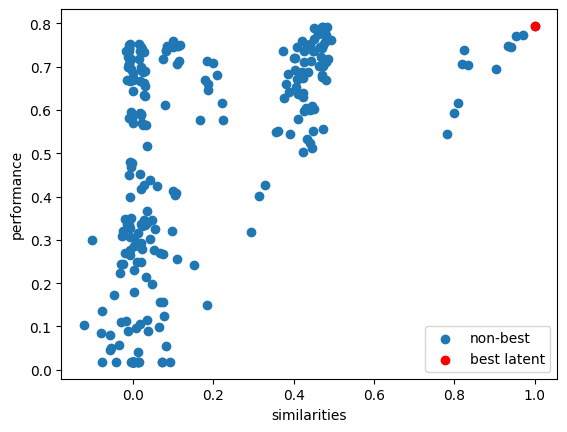

In [58]:
plt.scatter(similarity_wrt_best, performance, label='non-best')

# Highlight best latents
print(best_performance)
plt.scatter(1, best_performance, color='red', label='best latent')


plt.xlabel("similarities")
plt.ylabel("performance")
plt.legend()

plt.show()